# Regression Notebook
## Main question of interest:
Which descriptors best predict potency?  How do we validate these?

Workflow:
1. Standard OLS --> F-statistic.
2. Reject the null hypothesis.
3. Visualize Optimality Proportionality --> Transform IC50 onto 1/IC50.
4. Visualize Correlations.
5. Mixed Selection on IC50.
6. Mixed Selection on 1/IC50.
7. Analysis.

## Import Libraries
<hr>

In [1]:
# Core
import numpy as np
import pandas as pd
import os
import subprocess
def install_package(name):
    sudoPassword = ''
    command = 'pip install ' + name
    p = os.system('echo %s|sudo -S %s' % (sudoPassword, command))

# Stats
from statsmodels.regression import linear_model
import statsmodels.api as sm

# ML
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression


# Visualization
from ggplot import *
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.plotly as py
import plotly.graph_objs as go


/Library/Python/2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Import Data
<hr>

Data provided from: https://www.dropbox.com/sh/c9mbk8e2e8jxqfy/AADSmMbdoZduyG7Eq0HwOTT_a?dl=0

### Series3_6.15.17_padel.csv
This contains the data on OSM-S-106 and other OSM compounds. The field "IC50" describes potency. Smaller IC50 corresponds to higher potency, but a value of zero is impossible. A value of >40 means that the compound lacks enough activity to be interesting to us. OSM-S-106 has IC50 = 0.036.

### *_decoys_padel.csv
8 data sets called *_decoys_padel.csv. These large data sets contain compounds predicted to have minimal or no activity (IC50 can be assigned >200?).

### Selleck_filtered_padel_corrected.csv
Selleck_filtered_padel_corrected.csv. This is a set of well-characterized drugs from a vendor. We wish to identify drugs most similar to OSM-S-106 and predicted to be potent.

In [2]:
# Read in main data
main_df = pd.read_csv("Series3_6.15.17_padel.csv")

# Read in placebos data
placebo_1 = pd.read_csv("Akt1_decoys_padel.csv")
placebo_2 = pd.read_csv("AmpC_decoys_padel.csv")
placebo_3 = pd.read_csv("cp3a4_decoys_padel.csv")
placebo_4 = pd.read_csv("cxcr4_decoys_padel.csv")
placebo_5 = pd.read_csv("HIVpr_decoys_padel.csv")
placebo_6 = pd.read_csv("HIVrt_decoys_padel.csv")
placebo_7 = pd.read_csv("Kif11_decoys_padel.csv")
#placebo_8 = pd.read_csv("Selleck_filtered_padel_corrected.csv")

# Append dumby response column.
placebo_1.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_1.shape[0])], dtype="float64"))) 
placebo_2.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_2.shape[0])], dtype="float64"))) 
placebo_3.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_3.shape[0])], dtype="float64"))) 
placebo_4.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_4.shape[0])], dtype="float64"))) 
placebo_5.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_5.shape[0])], dtype="float64"))) 
placebo_6.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_6.shape[0])], dtype="float64"))) 
placebo_7.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_7.shape[0])], dtype="float64"))) 
#placebo_8.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_8.shape[0])], dtype="float64"))) 

# Gather our dataframes for collective manipulation
frames = [main_df,   placebo_1, placebo_2, 
          placebo_3, placebo_4, placebo_5,
          placebo_6, placebo_7]


## Remove NAs

In [6]:
# It only makes sense to keep non-null responses.
row_mask=frames[0].isnull().any(axis=1) == False
frames[0] = frames[0].loc[row_mask,:]

# Exploring Question (1)

Lets explore questions (1) above, which descriptors best predict potency?

Lets assume for a short moment that we know for sure our dataset is has a linear fit.

1. Do the parameters show us that there exists a relationship between our predictors and response (I.e., f-test)? If so, what is the confidence interval associated with the true parameters that influence IC50?

2. Which parameters shows us the most relationship with our response? If we had to cleanse our dataset down to a smaller representative subset of variables, what would they be (I.e., which p-values have the smallest amount indepedently, and largest indepedently; intentionally avoiding interaction for now).

3. Which of our parameters show us the most <em>interaction</em> between them. So, as they both move up together, the reponse is particularly higher or lower than if they were to equally increase separately.

Lets explore some of these questions.

#### Note, I want to explore this before we insert placebo data. This is important to see which features purely influence IC50 the most. However, knowing what purely does not influence IC50 might serve us some good later also.

In [109]:
# 1. Does there exist a relationship between chemical compounds and IC50?
main_df_X = sm.add_constant(frames[0].iloc[:,2:]).as_matrix()
print main_df_X.shape
main_df_y = frames[0].iloc[:,1].as_matrix()
print main_df_y.shape

pipe = Pipeline([('scaler',StandardScaler())])

frames[0].iloc[:,1:]=pipe.fit_transform(frames[0].iloc[:,1:])


model = sm.OLS(frames[0].iloc[:,1], frames[0].iloc[:,2:])
results = model.fit()
print(results.summary())


(46, 1444)
(46,)


/Library/Python/2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


                            OLS Regression Results                            
Dep. Variable:                   IC50   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.175e+05
Date:                Sat, 28 Apr 2018   Prob (F-statistic):            0.00170
Time:                        12:53:22   Log-Likelihood:                 304.95
No. Observations:                  46   AIC:                            -519.9
Df Residuals:                       1   BIC:                            -437.6
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
nAcid             -4.292e-05   9.46e+0

' Maximum Recursion Depth Exceeded ?\n\n# ... because IC50~. doesnt work for all variables -_-\'\nvariables=\'+\'.join([i+\' + \' for i in main_df.iloc[:,2:].columns])\nf="IC50 ~ " + variables \n\nmodel = sm.OLS.from_formula(formula=f, data=main_df.iloc[:,1:])\nresults = model.fit()\nprint(results.summary())\n\n'

### Optimality Proportionality

Instead of binning, is there a better way to express the relationship between the samples in the IC50? If we could find this out, we would know a relationship as IC50 gets less and less potent.


In [25]:
#frames[0].drop("optimality_proportion", axis=1, inplace=True)
frames[0].insert(2, "optimality_proportion", frames[0].apply(lambda row: (0.036/row[1]), axis=1))
frames[0]["optimality_proportion"].transform(lambda row: row*100)
frames[0].head()

,Name,IC50,optimality_proportion,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,...,AMW,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb
0,OSM-S-106,0.036,1.00000,0.0,-1.163538,0.315400,-0.675965,-0.299510,0.252031,0.322013,...,0.027437,-0.140782,-0.686883,0.489496,0.409928,0.236297,-0.351897,-0.071512,-0.915813,-0.043912
1,OSM-S-107,10.000,0.00360,0.0,1.245598,0.442840,0.309767,0.516043,0.252031,0.079184,...,-0.713072,0.496146,1.483096,-0.124775,-1.164199,1.120181,0.323597,0.227537,0.661334,0.412209
2,OSM-S-118,50.000,0.00072,0.0,0.641735,-0.503697,-1.694711,-0.988028,0.252031,0.322013,...,-0.336402,-0.958666,1.622023,-1.851884,-1.164199,-1.719711,-0.941983,-1.068339,1.306822,-1.021315
3,OSM-S-119,50.000,0.00072,0.0,2.390914,3.918852,-0.533123,-0.579726,0.252031,0.322013,...,2.174619,-0.632071,0.519600,-0.932947,-1.164199,-1.717171,-0.764698,-0.470243,1.863763,-0.630354
4,OSM-S-120,50.000,0.00072,0.0,1.439463,0.876467,-1.103317,-0.783877,0.252031,0.322013,...,0.919109,-0.794788,1.053901,-1.392159,-1.164199,-1.717166,-0.853988,-0.868974,1.585292,-0.825835


### Visualize Optimality Proportionality

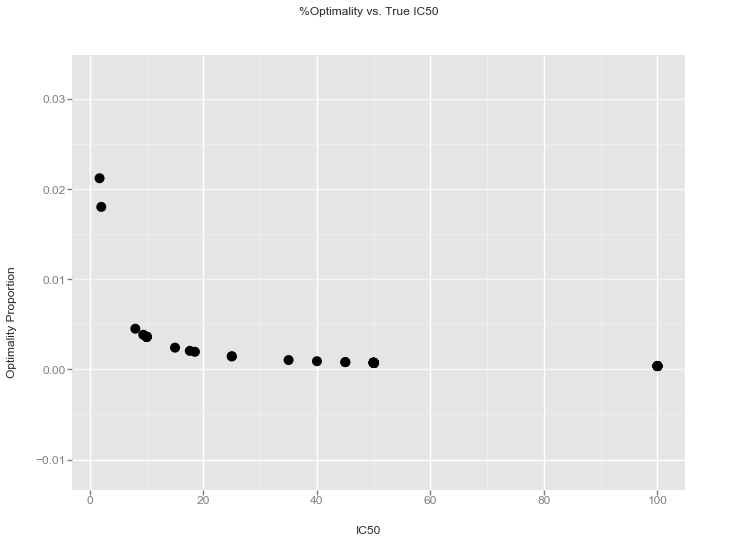

<ggplot: (291945277)>

In [144]:
p = ggplot(aes(x='IC50', y="optimality_proportion"), data=frames[0].iloc[1:,]) +\
    geom_point(size=100) +\
    ggtitle("%Optimality vs. True IC50") +\
    xlab("IC50") +\
    ylab("Optimality Proportion")
p

### Transform IC50: (1/IC50)


/Library/Python/2.7/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


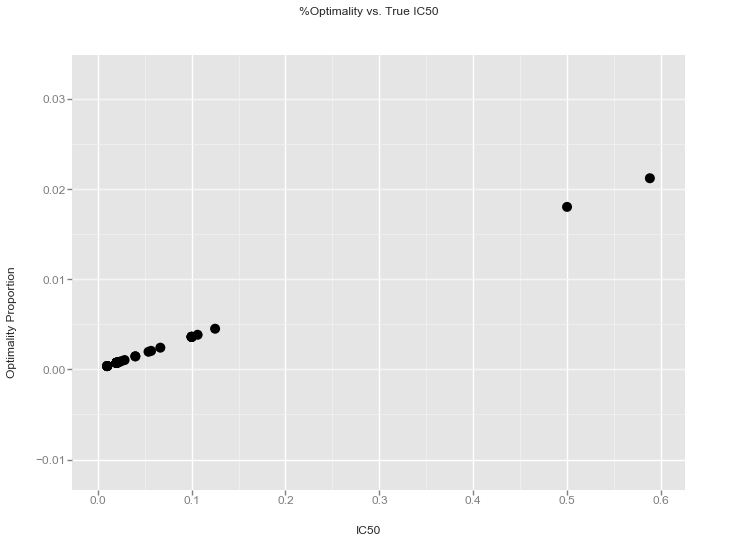

<ggplot: (291284609)>

In [145]:
frames[0]["IC50"].iloc[1:,] = frames[0]["IC50"].iloc[1:,].transform(lambda x:1/x)

p = ggplot(aes(x='IC50', y="optimality_proportion"), data=frames[0].iloc[1:,]) +\
    geom_point(size=100) +\
    ggtitle("%Optimality vs. True IC50") +\
    xlab("IC50") +\
    ylab("Optimality Proportion")
p

## Analysis of Optimality Proportionality

Since we know what optimal looks like in terms of IC50, the best was 0.036, we explored what proportion each sample produced holding the sample as the baseline and the optimal IC50 as the proportion. Doing this we produced a proportion of optimality. So if you have a small 0.036/x proportion, you are less potent, whereas if you are the ideal potency (IC50 itself), you will be = 1. This bounds us between [0,1] respectively for high or low optimality proportionalities.

Following this, we noticed a clear 1/x relationship between our indepdent IC50 (excluding the optimality point itself) and the depdent optimality proportion. This bids us to transform our independet variable by the 1/x.

From this transformation of IC50, we see a clear linear relationship with the dependent variable (the proportion of optimality w.r.t the independent point). Another way of stating this is as follows: As (1/IC50) increases (0.0306/IC50) increases positivly, strongly, and linearly!

What does this mean for us though?

It logically follows that if we are to obtain estimates from our features, and we are assuming linearity, it will provide an aid to our estimator if the response was learning 1/IC50 responses rather than just IC50 (the provided IC50). We have captured a dimension that was not explicitely drawn from the initial data set, that would have otherwise gone unnoticed. We cannot assume the linearity between our features, but we can see a proportional increase of our response. This may only contribute value if/when in our analysis we decide to weigh the responses in a custom error of sorts. 

In [157]:
frames[0].head()

,Name,IC50,optimality_proportion,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,...,AMW,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb
0,OSM-S-106,0.036,1.00000,0,-1.0958,1.200778,23.1572,39.591930,15,17,...,10.200817,40.713610,2.035681,22.242022,4.765434,11.047825,799,31,0.727,110
1,OSM-S-107,0.100,0.00360,0,1.1547,1.333332,38.0230,49.112481,15,16,...,8.202895,48.001779,2.087034,18.848454,0.000000,13.231952,1321,34,3.185,124
2,OSM-S-118,0.020,0.00072,0,0.5906,0.348808,7.7935,31.554344,15,17,...,9.219166,31.354825,2.090322,9.306953,0.000000,6.214417,343,21,4.191,80
3,OSM-S-119,0.020,0.00072,0,2.2246,4.948845,25.3114,36.320758,15,17,...,15.993993,35.091951,2.064232,14.383663,0.000000,6.220694,480,27,5.059,92
4,OSM-S-120,0.020,0.00072,0,1.3358,1.784362,16.7123,33.937551,15,17,...,12.606580,33.230029,2.076877,11.846725,0.000000,6.220707,411,23,4.625,86


## Correlation Matrix

Are there any interesting/concerning correlation areas?

There is a lot of pink, which illustrates no correlation between variables. One might argue, just visually, there is more uncorrelated variables than correlated.

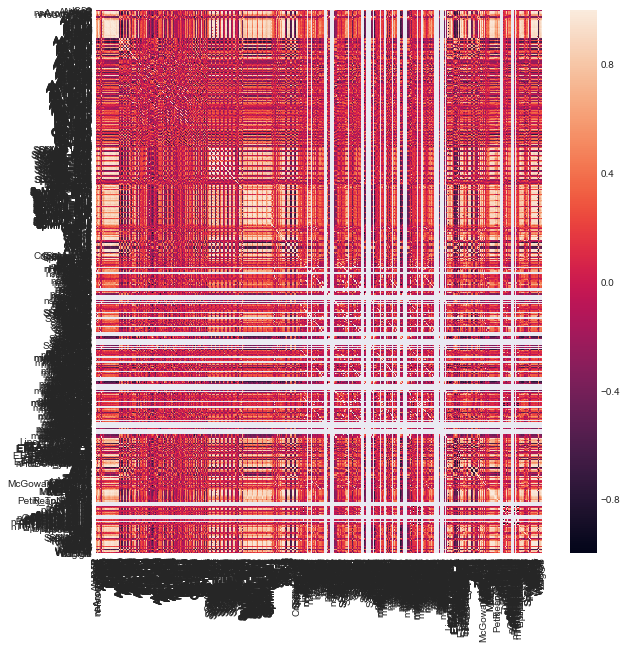

In [244]:
#frames[0].drop("optimality_proportion", axis=1, inplace=True)
corre= pd.DataFrame(np.corrcoef(frames[0].iloc[:,1:],rowvar=False), 
                    columns=frames[0].iloc[:,1:].columns,
                    index=frames[0].iloc[:,1:].columns,
                    dtype=np.float64)

fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(corre.as_matrix(),
            xticklabels=corre.index.tolist(),
            yticklabels=corre.index.tolist(),
            ax=ax)

plt.show()



### Change counts to categoricals

In [10]:
frames[0].dtypes.tolist()
colNames = frames[0].columns[frames[0].columns.str.contains(pat = 'n')]

for name in colNames:
    frames[0][name] = frames[0][name].astype('category')


/Library/Python/2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Name            object
IC50           float64
nAcid         category
ALogP          float64
ALogp2         float64
AMR            float64
apol           float64
naAromAtom    category
nAromBond     category
nAtom         category
nHeavyAtom    category
nH            category
nB            category
nC            category
nN            category
nO            category
nS            category
nP            category
nF            category
nCl           category
nBr           category
nI            category
nX            category
ATS0m          float64
ATS1m          float64
ATS2m          float64
ATS3m          float64
ATS4m          float64
ATS5m          float64
ATS6m          float64
                ...   
MWC3           float64
MWC4           float64
MWC5           float64
MWC6           float64
MWC7           float64
MWC8           float64
MWC9           float64
MWC10          float64
TWC            float64
SRW2           float64
SRW3             int64
SRW4           float64
SRW5       

# Mixed Selection

Since we saw our f-statistic as 207100, we can certainly reject the null with statistical significance in favor that there exists <em>A</em> relationship among our variables and the response. But the next natural question is, which ones were the most influencial? For this we use mixed selection.

## Intuition:

This is a combination of forward and backward selection. We start with no variables in the mode, and as with forward selection, we add the variable that provides the best fit. We continue to add variables one by one. Of course, the p-values for variables can become larger as new predictors are added to the mode. Hence, if at any point the p-vaue for one of the variables inthe model rises above a certain threshold, then we remove that variable from the model.  We continue to perform these forward and backwarded steps until all variables in the model have a sufficiently low p-value, and all variables outside the mode would have a large p-value if added to the model.

This eliminates the case in which we start with a super high valued p-value, making it the golden standard (forward selection) or removing under-valued p-value, making it hard to keep indepedently strong features (backward selection). Effectively, we will be left with the <em>optimal set of variables</em> that had the highest influence on the response.


In [11]:
def mixed_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
                                                      
        best_pval = new_pval.min()
        
        

        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            #best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            #worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))

        if not changed:
            break

    
    return included


def forward_selection(X, y, 
                       initial_list=[],
                       verbose=True,
                       scoring="r2"):
    """ Perform a forward feature selection 
    based on R^2 value returned from each column
    appended into the model
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        verbose - whether to print the sequence of inclusions and exclusions
        scoring - the measure of error for the cross validation.
    Returns: dictionary, key:score value, value: tuple(Model_Object, Set_of_features) 
    """
    included = list(initial_list)
    M = {}
    best_r2=False
    
    # forward step
    excluded = list(set(X.columns)-set(included))
    new_rval = []
    for new_column in excluded:                

        included = included + [new_column]
        Mk = LinearRegression().fit(X[included],y)
        r2 = np.mean(cross_val_score(Mk, X[included], y=y, scoring=scoring, cv=3))
        new_rval.append(r2)
        M[r2] = (Mk, included)
        if verbose:
            print ("Columns:", included,".\nR2=",str(r2))

    
    best_r2 = max(new_rval)
    print ("Best r2:", best_r2)
    
    return M[best_r2]



## Execute Mixed Selection

R^2 between runs

In [12]:
# Scale/center data
frames[0].loc[:,2:] = StandardScaler().fit_transform(frames[0].iloc[:,2:])

/Library/Python/2.7/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [13]:
result_pvalues_stepwise_std = mixed_selection(frames[0].iloc[:,2:],
                                              frames[0].iloc[:,1],
                                              threshold_in=0.1,
                                              threshold_out=0.2,
                                              verbose=True)
result_pvalues_stepwise_std

/Library/Python/2.7/site-packages/statsmodels/base/model.py:1036: RuntimeWarning:

invalid value encountered in divide

/Library/Python/2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning:

invalid value encountered in greater

/Library/Python/2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning:

invalid value encountered in less

/Library/Python/2.7/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning:

invalid value encountered in less_equal



Add  BCUTw-1l                       with p-value 5.26858e-05
Add  AATSC0i                        with p-value 0.000557545
Add  ATSC8v                         with p-value 0.000252404
Add  MATS4s                         with p-value 0.00904015
Add  minssNH                        with p-value 0.00369113
Add  SHBint4                        with p-value 0.00962978
Add  minHBint10                     with p-value 0.00615735
Add  ATSC8p                         with p-value 0.0212044
Add  VE1_Dzi                        with p-value 0.00966146
Add  VE2_Dzs                        with p-value 0.0104817
Add  minHBint4                      with p-value 0.00733809
Add  ATSC7s                         with p-value 0.0875887
Add  maxHsNH2                       with p-value 0.0208171
Add  maxsNH2                        with p-value 0.0163927
Add  minHdsCH                       with p-value 0.0734617
Add  MATS7s                         with p-value 0.0227241
Add  MATS2m                         with p-v

['BCUTw-1l',
 'AATSC0i',
 'ATSC8v',
 'MATS4s',
 'minssNH',
 'SHBint4',
 'minHBint10',
 'ATSC8p',
 'VE1_Dzi',
 'minHBint4',
 'ATSC7s',
 'maxHsNH2',
 'maxsNH2',
 'minHdsCH',
 'MATS7s',
 'MATS2m',
 'VE2_D',
 'AATSC1i',
 'SIC3',
 'minHBint9',
 'VR2_Dzv',
 'MDEO-22',
 'MATS8m',
 'VE1_Dt',
 'VR2_Dzm',
 'GATS3c',
 'AATSC5m',
 'topoShape',
 'minHsNH2',
 'SsssCH',
 'GATS8c',
 'nHBDon_Lipinski',
 'JGI7']

In [14]:
# Consider the optimality proportionality transformation.
result_pvalues_stepwise_trans = mixed_selection(frames[0].iloc[:,2:],
                                                frames[0].iloc[:,1].transform(lambda x:1/x),
                                                threshold_in=0.1,
                                                threshold_out=0.2,
                                                verbose=True)
result_pvalues_stepwise_trans

Add  MDEN-11                        with p-value 0.00263085
Add  AATSC8s                        with p-value 0.0151325
Add  ndssC                          with p-value 0.0860594
Add  minHBint2                      with p-value 0.045492
Add  SHBint2                        with p-value 0.000482505
Add  maxHBint2                      with p-value 0.000159384
Add  VE3_Dzs                        with p-value 0.0018714
Add  ATSC7c                         with p-value 0.00203548
Add  BCUTp-1l                       with p-value 0.00109687
Add  SpMin8_Bhi                     with p-value 0.0304903
Add  VR2_Dzi                        with p-value 0.00702756
Add  MLFER_E                        with p-value 0.00106939
Add  C1SP3                          with p-value 0.0191353
Add  naasC                          with p-value 0.0234689
Add  topoShape                      with p-value 0.0404735
Add  BCUTw-1l                       with p-value 0.0850085
Add  AATSC8c                        with p-value

/Library/Python/2.7/site-packages/statsmodels/regression/linear_model.py:1353: RuntimeWarning:

divide by zero encountered in double_scalars

/Library/Python/2.7/site-packages/statsmodels/base/model.py:1118: RuntimeWarning:

invalid value encountered in multiply



Add  MDEN-33                        with p-value 0.00229692


['MDEN-11',
 'AATSC8s',
 'ndssC',
 'minHBint2',
 'SHBint2',
 'maxHBint2',
 'VE3_Dzs',
 'ATSC7c',
 'BCUTp-1l',
 'SpMin8_Bhi',
 'VR2_Dzi',
 'MLFER_E',
 'C1SP3',
 'naasC',
 'topoShape',
 'BCUTw-1l',
 'AATSC8c',
 'MATS8c',
 'VR2_Dzm',
 'ETA_dAlpha_B',
 'GATS8m',
 'nHBint9',
 'SpMin7_Bhm',
 'SpMax5_Bhm',
 'ZMIC1',
 'SCH-5',
 'ATS4m',
 'MDEO-12',
 'AATS6m',
 'AATS0v',
 'GATS6s',
 'SpMin4_Bhi',
 'MATS3c',
 'GATS1s',
 'ATS8m',
 'minssO',
 'VR1_Dzi',
 'GATS4p',
 'nHBint4',
 'nX',
 'ATS5m',
 'SaaS',
 'SsNH2',
 'SpMin3_Bhs',
 'nBase',
 'MDEN-33']

In [31]:
# What do each mixed_selections have in common?
set(result_pvalues_stepwise_trans).intersection(result_pvalues_stepwise_std)
len(result_pvalues_stepwise_std)
len(result_pvalues_stepwise_trans)

46

## Conjecture:

We make the conjecture that the following variables relate the most to informing IC50 potency in descending order.

<em>Counter arguments should include</em>:
1. Linearity assumption of chemical compounds. 
2. Interactions effects are not considered.
3. Hypothesis tests acceptance variables with no more than 10% probability of rejecting the null. This is a 90% confidence interval, which is not the standard 95%.

### Mixed Selection Results

### <em>OLS Indepdent Features (Highest Probability of having a true relationship with potency)</em>
A simple ordinary least squares model.

<strong>Transformation: None</strong>
<code>
Add  BCUTw-1l                       with p-value 5.26858e-05
Add  AATSC0i                        with p-value 0.000557545
Add  ATSC8v                         with p-value 0.000252404
Add  MATS4s                         with p-value 0.00904015
Add  minssNH                        with p-value 0.00369113
Add  SHBint4                        with p-value 0.00962978
Add  minHBint10                     with p-value 0.00615735
Add  ATSC8p                         with p-value 0.0212044
Add  VE1_Dzi                        with p-value 0.00966146
Add  VE2_Dzs                        with p-value 0.0104817
Add  minHBint4                      with p-value 0.00733809
Add  ATSC7s                         with p-value 0.0875887
Add  maxHsNH2                       with p-value 0.0208171
Add  maxsNH2                        with p-value 0.0163927
Add  minHdsCH                       with p-value 0.0734617
Add  MATS7s                         with p-value 0.0227241
Add  MATS2m                         with p-value 0.0370664
Add  VE2_D                          with p-value 0.0716549
Add  AATSC1i                        with p-value 0.0575872
Add  VE2_Dze                        with p-value 0.0782014
Add  SIC3                           with p-value 0.0263716
Drop VE2_Dzs                        with p-value 0.544928
Add  minHBint9                      with p-value 0.0621038
Add  VR2_Dzv                        with p-value 0.0666585
Add  MDEO-22                        with p-value 0.0286973
Add  MATS8m                         with p-value 0.0749992
Add  VE1_Dt                         with p-value 0.0315953
Add  VR2_Dzm                        with p-value 0.0236412
Add  GATS3c                         with p-value 0.0100665
Drop VE2_Dze                        with p-value 0.417278
Add  AATSC5m                        with p-value 0.0370049
Add  topoShape                      with p-value 0.00707281
Add  minHsNH2                       with p-value 0.0116271
Add  SsssCH                         with p-value 0.0577545
Add  GATS8c                         with p-value 0.0474065
Add  nHBDon_Lipinski                with p-value 0.0120816
Add  JGI7                           with p-value 0.032504
</code>

<strong> Transformation: 1/x </strong>
<code>
Add  MDEN-11                        with p-value 0.00263085
Add  AATSC8s                        with p-value 0.0151325
Add  ndssC                          with p-value 0.0860594
Add  minHBint2                      with p-value 0.045492
Add  SHBint2                        with p-value 0.000482505
Add  maxHBint2                      with p-value 0.000159384
Add  VE3_Dzs                        with p-value 0.0018714
Add  ATSC7c                         with p-value 0.00203548
Add  BCUTp-1l                       with p-value 0.00109687
Add  SpMin8_Bhi                     with p-value 0.0304903
Add  VR2_Dzi                        with p-value 0.00702756
Add  MLFER_E                        with p-value 0.00106939
Add  C1SP3                          with p-value 0.0191353
Add  naasC                          with p-value 0.0234689
Add  topoShape                      with p-value 0.0404735
Add  BCUTw-1l                       with p-value 0.0850085
Add  AATSC8c                        with p-value 0.0484744
Add  WTPT-4                         with p-value 0.0221954
Add  MATS8c                         with p-value 0.0123605
Add  VR2_Dzm                        with p-value 0.00412303
Add  ETA_dAlpha_B                   with p-value 0.00111288
Add  GATS8m                         with p-value 0.0329013
Add  nHBint9                        with p-value 0.0430933
Add  SpMin7_Bhm                     with p-value 0.0174613
Add  SpMax5_Bhm                     with p-value 0.00442855
Add  ZMIC1                          with p-value 0.0259496
Add  SCH-5                          with p-value 0.0374916
Add  ATS4m                          with p-value 0.0571946
Add  MDEO-12                        with p-value 0.0169577
Add  AATS6m                         with p-value 0.00483877
Add  AATS0v                         with p-value 0.000203569
Add  GATS6s                         with p-value 0.000857447
Add  SpMin4_Bhi                     with p-value 0.00165968
Add  MATS3c                         with p-value 0.00497439
Add  GATS1s                         with p-value 0.00347799
Add  ATS8m                          with p-value 0.00215977
Add  minssO                         with p-value 0.0128571
Add  VR1_Dzi                        with p-value 0.0007765
Add  GATS4p                         with p-value 0.00459402
Add  nHBint4                        with p-value 0.00393504
Add  nX                             with p-value 0.00661781
Add  ATS5m                          with p-value 0.0099791
Add  SaaS                           with p-value 0.000821049
Add  SsNH2                          with p-value 1.52844e-05
Add  SpMin3_Bhs                     with p-value 0.00171424
Add  nBase                          with p-value 0.00229692
Add  MDEN-33                        with p-value 0.00229692
</code>

### Set intersection between both lists
<code>{'BCUTw-1l', 'VR2_Dzm', 'topoShape'}</code>


## Stepwise Selection (Mixed) Output $$p-values$$

Excluding interactions, with a acceptance tolerance of 10% (p=0.1 I.e., If our min pval is lower; accept that variable) and rejectance tolerance of 20% (p=0.2 I.e., If our max pval is higher; reject that variable). These are the most highly interactive set of attributes with statistical signigance under linear assumptions. Whether the 1/x transformation makes a difference is up to domain experts.

What we can say is that this is a list of important features, but what we cannot guarentee is that this is the best set or optimal set of important features. This analysis can be further augmented with decision tree classifiers/regressors to determine feature importance, as well as OR techniques such as MADM.